![](images/feature-engineering.png)

# Finding structure

We'll start by loading our training data.

In [1]:
import pandas as pd
data = pd.read_parquet("data/training.parquet")

Our training data consists of labels (either `legitimate` or `spam`) and short documents of plausible English text.

The process of turning real-world data into a form that a machine learning algorithm can take advantage of is called *feature engineering*.  We're going to use an approach called TF-IDF in this notebook.

In [2]:
from sklearn.feature_extraction.text import HashingVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
import pickle, os

vect = HashingVectorizer(norm=None, token_pattern='(?u)\\b[A-Za-z]\\w+\\b', n_features=1024, alternate_sign = False)

tfidf = TfidfTransformer()

feat_pipeline = Pipeline([
    ('vect',vect),
    ('tfidf',tfidf)
])

from mlworkflows import util
util.serialize_to(feat_pipeline, "feature_pipeline.sav")

In [3]:
feature_vecs = feat_pipeline.fit_transform(data["text"]).toarray()
labeled_vecs = pd.concat([data.reset_index()[["index", "label"]],
                                pd.DataFrame(feature_vecs)], axis=1)
labeled_vecs.columns = labeled_vecs.columns.astype(str)
labeled_vecs.to_parquet("data/features.parquet")

In [5]:
import sklearn.decomposition

DIMENSIONS = 2

pca2 = sklearn.decomposition.TruncatedSVD(DIMENSIONS)

pca_a = pca2.fit_transform(labeled_vecs[labeled_vecs.columns[2:]].values)

Let's plot these points to see if there's some structure in our data.

/Users/willb/anaconda/envs/jupyter/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


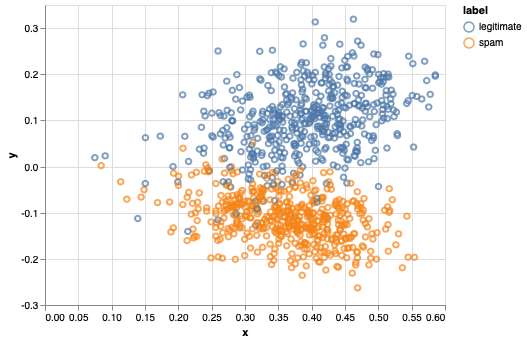

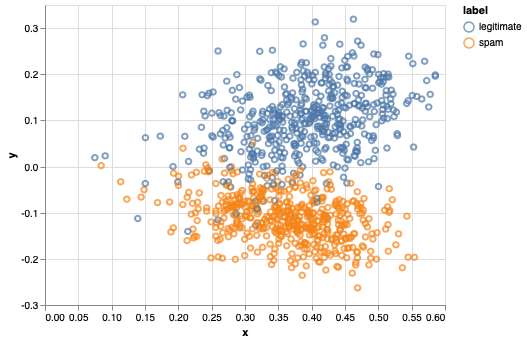

In [6]:
pca_df = pd.DataFrame(pca_a, columns=["x", "y"])
pca_df.sample(10)

plot_data = pd.concat([data.reset_index(), pca_df], axis=1)

import altair as alt
alt.renderers.enable('notebook')

alt.Chart(plot_data.sample(1000)).encode(x="x", y="y", color="label").mark_point().interactive()